In [7]:
import sys
sys.path.append('/home/jeffrey_alstott/technoinnovation/technologytimeseries_forecasting/src/AI-metrics/')

In [8]:
from scrapers.atari import simple_games

Failed to load local paper cache, trying a network copy...


Traceback (most recent call last):
  File "/home/jeffrey_alstott/technoinnovation/technologytimeseries_forecasting/src/AI-metrics/taxonomy.py", line 444, in __init__
    with open(".paper_cache.json") as f:
FileNotFoundError: [Errno 2] No such file or directory: '.paper_cache.json'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/home/jeffrey_alstott/technoinnovation/technologytimeseries_forecasting/src/AI-metrics/taxonomy.py", line 450, in __init__
    self.cache = json.loads(req.content, object_hook=parse_date)
  File "/home/jeffrey_alstott/anaconda3/lib/python3.5/json/__init__.py", line 312, in loads
    s.__class__.__name__))
TypeError: the JSON object must be str, not 'bytes'


(Continuing with an empty cache)
Caching paper name: Playing Atari with Deep Reinforcement Learning
Caching paper name: Evolution Strategies as a Scalable Alternative to Reinforcement Learning
Caching paper name: A Distributional Perspective on Reinforcement Learning
Caching paper name: Learning functions across many orders of magnitudes
Caching paper name: None
Caching paper name: Deep Reinforcement Learning with Double Q-learning
Caching paper name: Deep Reinforcement Learning with Double Q-learning
Caching paper name: Dueling Network Architectures for Deep Reinforcement Learning
Caching paper name: Prioritized Experience Replay
Caching paper name: Dueling Network Architectures for Deep Reinforcement Learning
Caching paper name: Bellemare
Caching paper name: The Arcade Learning Environment: An Evaluation Platform for General Agents
Caching paper name: Asynchronous Methods for Deep Reinforcement Learning
Caching paper name: Massively Parallel Methods for Deep Reinforcement Learning


In [9]:
import pandas as pd
import seaborn as sns
sns.set_color_codes()
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [10]:
date_to_forecast_to = datetime.date(2020,1,31)

In [11]:
names = [q.name[11:] for q in simple_games.metrics]
import calendar
# Round dates to nearest month, which means changing the day to the last day of that month.
convert_to_end_of_month = lambda x: x.replace(day=calendar.monthrange(x.year, x.month)[1])
dates = [[convert_to_end_of_month(r.date) for r in q.measures] for q in simple_games.metrics]
dates_ind = unique(sum(dates))

df = pd.DataFrame(columns=names, index=pd.date_range(dates_ind[0], date_to_forecast_to, freq='M'),dtype='float')
for q in simple_games.metrics:
    for r in q.measures:
        df.loc[convert_to_end_of_month(r.date), q.name[11:]] = max(r.maxval, df.loc[convert_to_end_of_month(r.date), q.name[11:]])

### Keep a copy of only record-breakers
dfr = df.copy()
for col in dfr.columns:
    dfr[col] = dfr[col].dropna().cummax().drop_duplicates().reindex(dfr.index)

/home/jeffrey_alstott/anaconda3/lib/python3.5/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


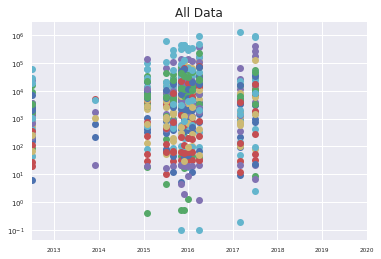

In [12]:
df.plot(marker='o', linewidth=0, legend=False)#, colors=sns.color_palette('viridis', df.shape[1]))
yscale('log')
title("All Data")

/home/jeffrey_alstott/anaconda3/lib/python3.5/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


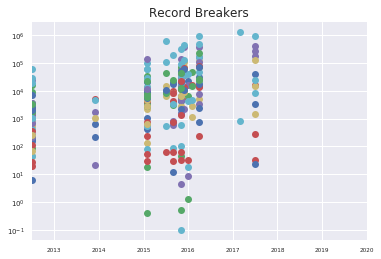

In [13]:
dfr.plot(marker='o', linewidth=0, legend=False)
yscale('log')
title("Record Breakers")

In [27]:
sys.path.append('/home/jeffrey_alstott/technoinnovation/')
sys.path.append('/home/jeffrey_alstott/technoinnovation/technologytimeseries_forecasting/src/')
from pystan_time_series import TimeSeriesModel
n_jobs = 4
n_iterations = 500
max_depth = 10

import stan_utility
def check_div(fit, parameters):
    div = concatenate([s['divergent__'] for s in fit.get_sampler_params(inc_warmup=False)]).astype('bool')

    if sum(div==0):
        print("\x1b[32m\"No divergences\"\x1b[0m")
    else:
        from ndtest import ks2d2s
        divergences = {}
        non_divergences = {}
        for parameter in parameters:
            divergences[parameter] = fit[parameter][div].squeeze()
            non_divergences[parameter] = fit[parameter][~div].squeeze()
            if divergences[parameter].ndim>2:
                N = divergences[parameter].shape[3]
                for n in arange(N):
                    divergences[parameter+'.%i'%n] = divergences[parameter][:,:,n]
                    non_divergences[parameter+'.%i'%n] = non_divergences[parameter][:,:,n]
                del divergences[parameter]
                del non_divergences[parameter]

            any_unevenly_distributed = False
            
            for k1 in divergences.keys():
                for k2 in divergences.keys():
                    if k1==k2:
                        continue

                    x = divergences[k1].ravel()
                    y = divergences[k2].ravel()

                    x_non = non_divergences[k1].ravel()
                    y_non = non_divergences[k2].ravel()

                    p = ks2d2s(x_non, y_non, x, y)
                    if p<.05:
                        any_unevenly_distributed = True
#                         figure()
#                         scatter(x_non, y_non,
#                            alpha=.1, label='Non-Divergent')
#                         scatter(x,y,
#                                alpha=1, label='Divergent')
#                         xlabel(k1)
#                         ylabel(k2)
#                         legend()
#                         title("KS test p=%.2f"%(p))
        if any_unevenly_distributed:
            print("\x1b[31m\"%.2f divergences, which appear to be non-spurious\"\x1b[0m"%(div.mean()))
        else:
            print("\x1b[32m\"%.2f divergences, which appear to be spurious\"\x1b[0m"%(div.mean()))
def test_model_fit(fit, parameters, max_depth=10):
    stan_utility.check_treedepth(fit,max_depth=max_depth)
    stan_utility.check_energy(fit)
    check_div(fit, parameters)

def plot_time_series_inference(model_fit, x=None,
                               ax=None, ind=0, D=1, **kwargs):
    from scipy.stats import scoreatpercentile
    ci_thresholds = [2.5, 25, 50, 75, 97.5]
    
    data = model_fit.squeeze()
    
    if data.ndim==3:
        data = data[:,ind,:]
    elif data.ndim>3:
        data = data[:,ind,:,D]
        
    CIs = scoreatpercentile(data, ci_thresholds, axis=0)
    CIs = pd.DataFrame(data=CIs.T, columns=ci_thresholds)
    if ax is None:
        ax=gca()
    if x is None:
        x = arange(data.shape[1])
    l = ax.plot(x, CIs[50], label='Median Forecast', **kwargs)
    c = l[0].get_color()
    ax.fill_between(x, CIs[2.5], CIs[97.5], alpha=.25, color=c, label='95% CI',# color=(0.27380900000000002, 0.031496999999999997, 0.35885299999999998),
                    **kwargs)
    ax.fill_between(x, CIs[25], CIs[75], alpha=.75, color=c, label='50% CI',# color=(0.94563600000000003, 0.89981500000000003, 0.11283799999999999),
                    **kwargs)

In [10]:
# initial_values = dfr.apply(lambda x: x[x.first_valid_index()])

# offset_for_negative_scores = abs(dfr.min().min())*2

# negative_scores = (dfr<0).sum()>0
# negative_scores = negative_scores[negative_scores].index

In [15]:
only_positive_scores = (dfr<=0).sum()==0
only_positive_scores = only_positive_scores[only_positive_scores].index

In [16]:
target_time_series = only_positive_scores

In [17]:
model = TimeSeriesModel(Y=log(dfr[target_time_series]),
                        use_partial_pooling=True, difference=[1], monotonic=[1])
model.sampling(n_jobs=n_jobs, iter=n_iterations, control={'max_treedepth':max_depth})

test_model_fit(model.fit, ['mu', 'sigma'], max_depth=max_depth)

"0 of 1000 iterations saturated the maximum tree depth of 10 (0.0%)"
"Chain 0: E-BFMI = 0.49407596054947417"
"Chain 1: E-BFMI = 0.5622038806509587"
"Chain 2: E-BFMI = 0.5105419965976866"
"Chain 3: E-BFMI = 0.49763438773726726"
"No divergences"


/home/jeffrey_alstott/anaconda3/lib/python3.5/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


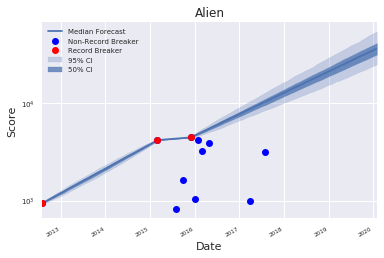

In [28]:
plot_time_series_inference(exp(model.fit['Y_latent']),ind=i, x=dfr.index)
df[target_time_series].iloc[:,i].plot(linewidth=0,marker='o', color='blue', label='Non-Record Breaker')
dfr[target_time_series].iloc[:,i].plot(linewidth=0,marker='o', color='red', label='Record Breaker')
yscale('log')
title(target_time_series[i])
ylabel('Score')
xlabel("Date")
legend(loc='best')

/home/jeffrey_alstott/anaconda3/lib/python3.5/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
/home/jeffrey_alstott/anaconda3/lib/python3.5/site-packages/matplotlib/pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


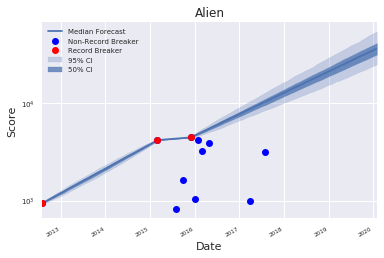

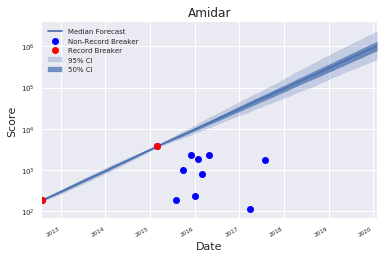

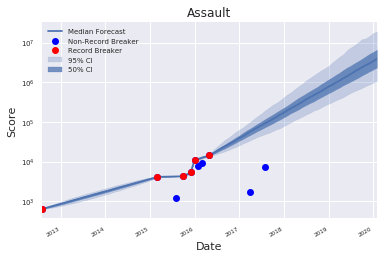

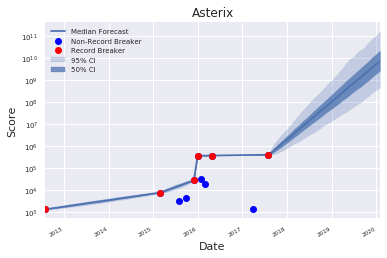

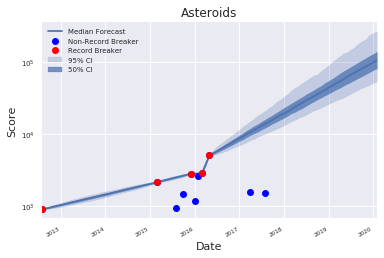

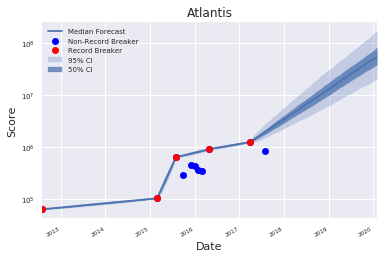

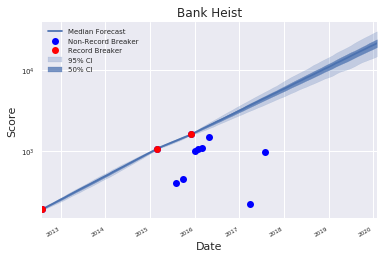

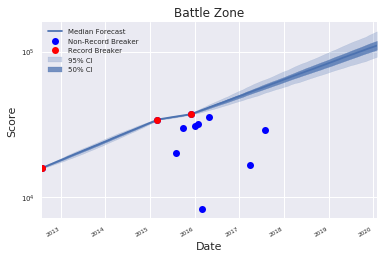

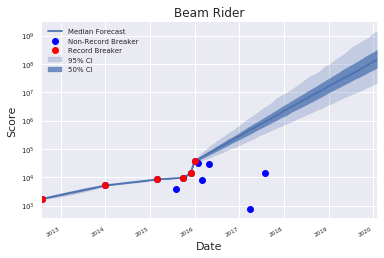

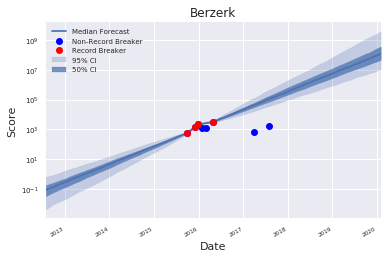

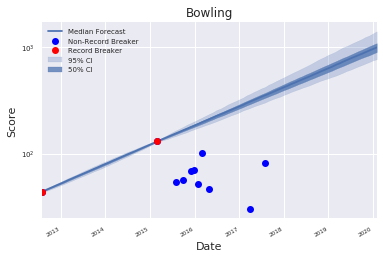

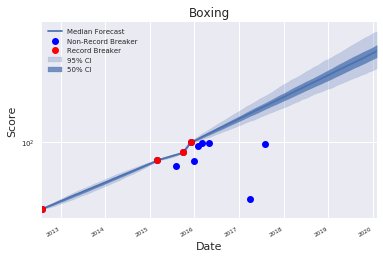

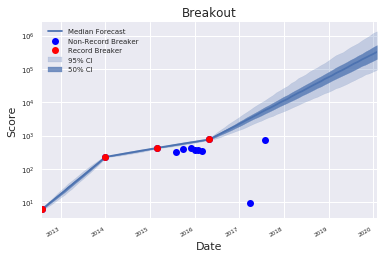

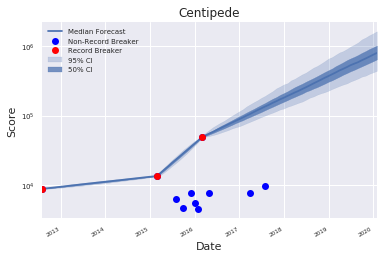

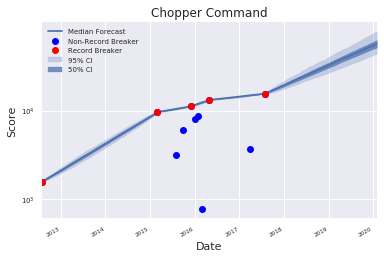

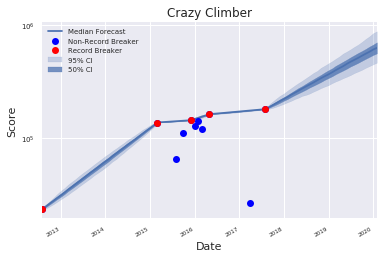

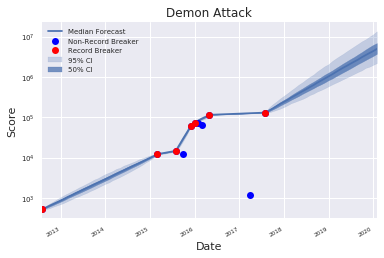

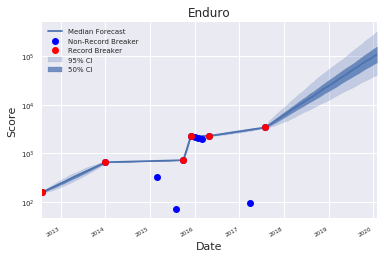

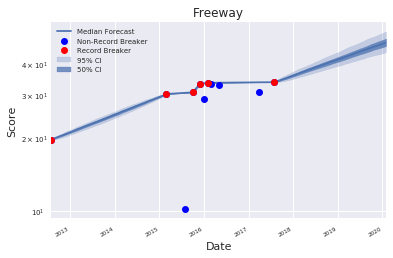

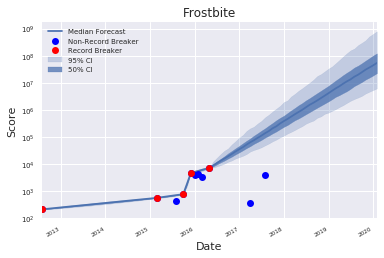

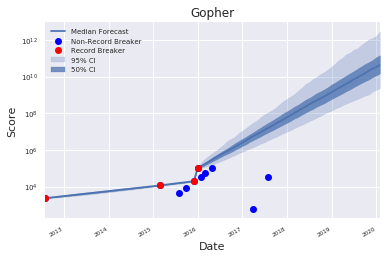

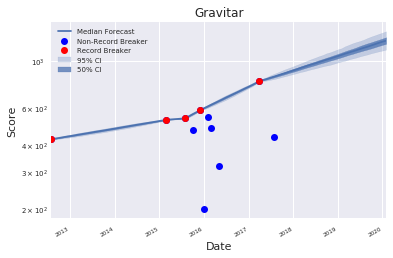

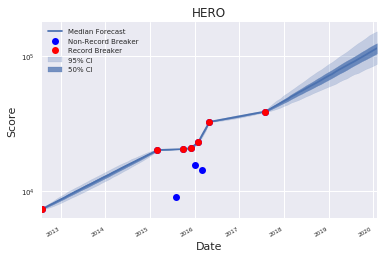

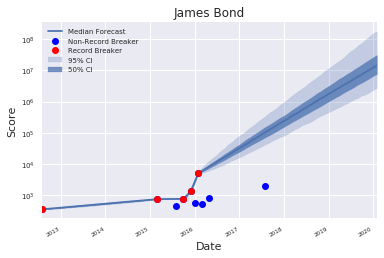

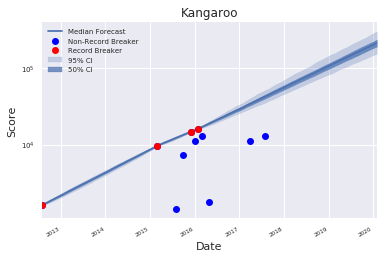

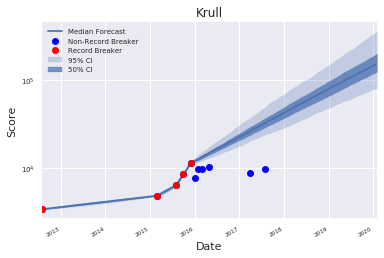

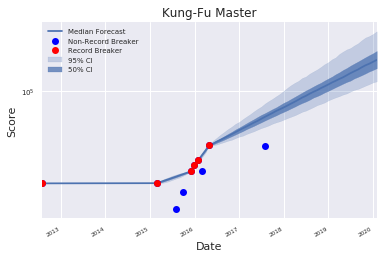

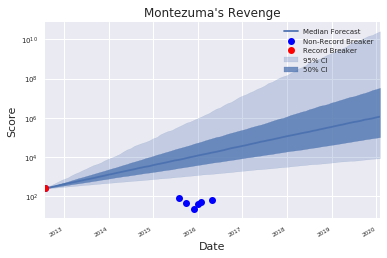

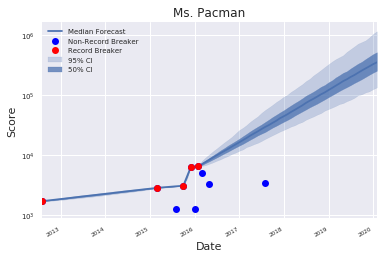

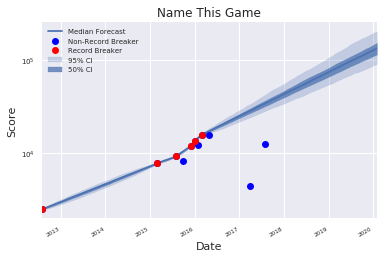

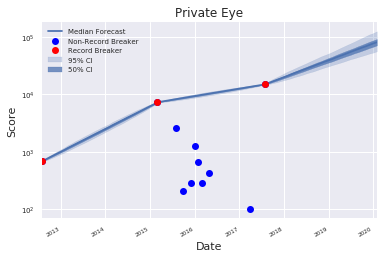

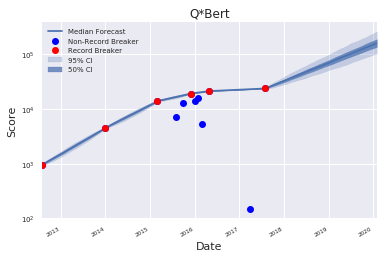

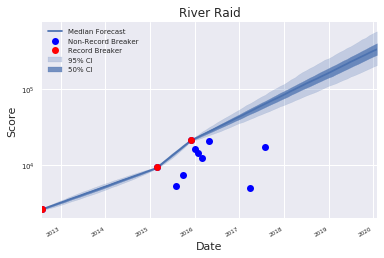

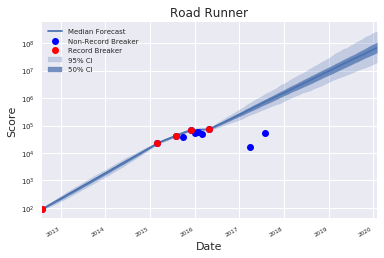

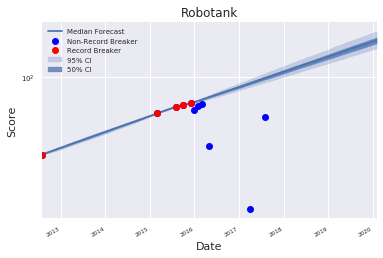

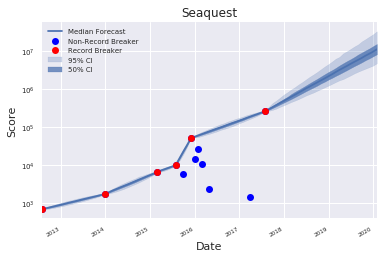

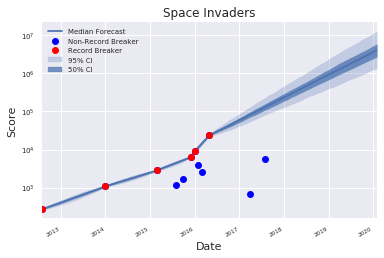

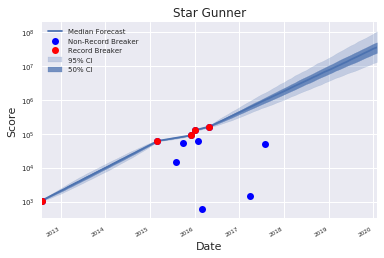

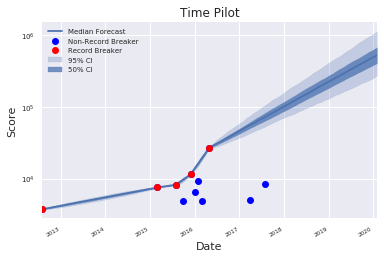

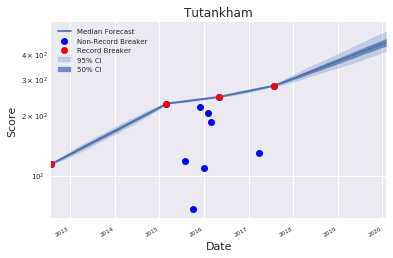

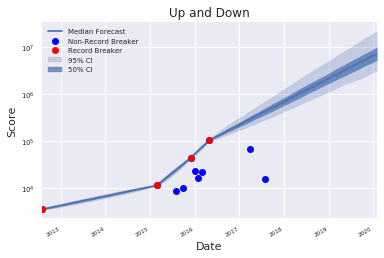

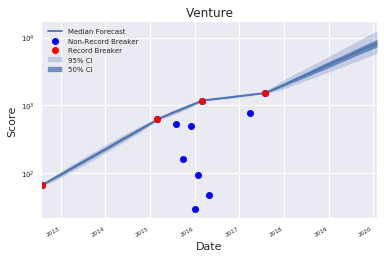

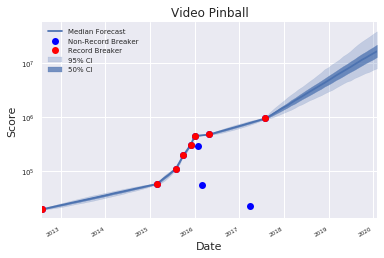

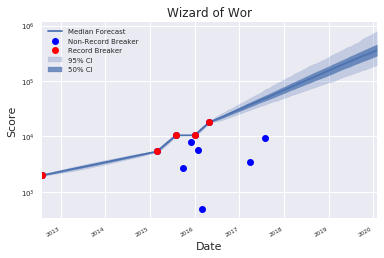

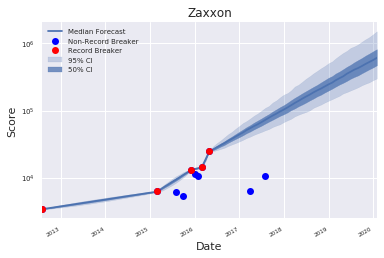

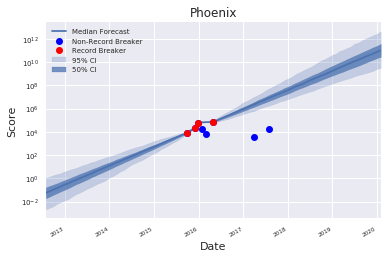

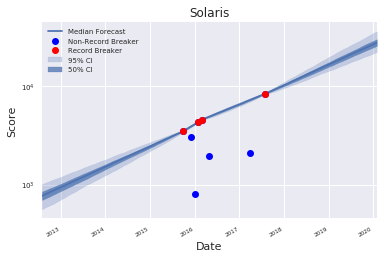

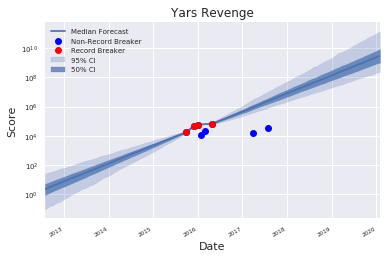

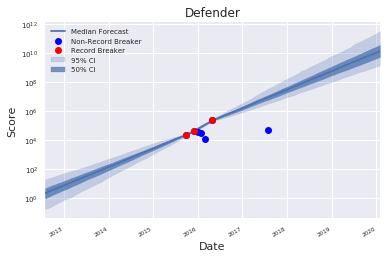

In [34]:
from matplotlib.backends.backend_pdf import PdfPages
plots = PdfPages('/home/jeffrey_alstott/Dropbox/Apps/ShareLaTeX/Forecasting_Technologies/figs/Atari_Forecasts.pdf')

for i in range(len(target_time_series)):
    fig = figure()
    plot_time_series_inference(exp(model.fit['Y_latent']),ind=i, x=dfr.index)
    df[target_time_series].iloc[:,i].plot(linewidth=0,marker='o', color='blue', label='Non-Record Breaker')
    dfr[target_time_series].iloc[:,i].plot(linewidth=0,marker='o', color='red', label='Record Breaker')
    yscale('log')
    title(target_time_series[i])
    ylabel('Score')
    xlabel("Date")
    legend(loc='best')
    plots.savefig(fig, bbox_inches='tight')
    
plots.close()